In [1]:
import numpy as np
import re
import random
import itertools
import datetime

import tensorflow as tf
import sklearn as sk

import Functions as fn
from DS import DS
from Set import pool
from Iterator import Iterator
from FFModel import FF_Model

# Data Loading

In [2]:
Dataset = pool()
Dataset.load_texts('raw_texts')
Dataset.load_labels('raw_labels')

Raw Text Load Complete
Raw Labels Load Complete


In [3]:
target_dict = fn.load_labels('labels')

Label Load Complete


# Embedding Generation

In [4]:
from gensim.models import Word2Vec
sentences = fn.load_sentences('sentences')

C:\Users\Luka\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Sentence Load Complete


In [5]:
#model = Word2Vec(sentences, min_count=1, size=100)
#model.save('W2V')

In [6]:
model = Word2Vec.load('W2V')
vocab = model.wv.vocab.keys()

# FFNN Testing

In [75]:
train_cases = pool((Dataset.get_DS(labelled='yes')).data[:50])
validation_cases = pool(Dataset.get_DS(labelled='yes').data[-50:-25])
test_cases = pool(Dataset.get_DS(labelled='yes').data[-25:])

train_cases.process_for_testing()
validation_cases.process_for_testing()
test_cases.process_for_testing()

In [76]:
sets = {}
sets['train_set'], sets['train_labels'], _ = train_cases.get_ff_sets(model)
sets['validation_set'], sets['validation_labels'], _ = validation_cases.get_ff_sets(model)
sets['test_set'], sets['test_labels'], sets['test_words'] = test_cases.get_ff_sets(model)

In [77]:
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))
fn.saturate_training_set_training(sets['train_set'], sets['train_labels'], 0.1)
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))

Ratio: med: 0.03% non-med: 0.97%
Ratio: med: 0.12% non-med: 0.88%


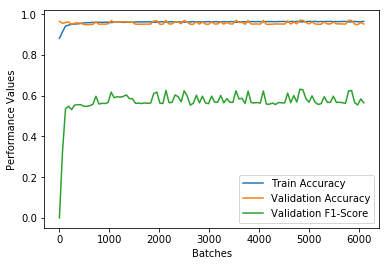

FInal Values: TrAcc: 0.965, ValAcc: 0.952, ValF1: 0.565
Test F1-Score: 0.603



In [78]:
NN = FF_Model(layers=[50])
NN.build_graph()
_,_,_,_ = NN.train(sets, epochs=5, batch=50, show_plot=True, show_progress=True)

In [79]:
res = NN.predict(sets['test_set'])
tru = np.argmax(sets['test_labels'], 1)

In [80]:
TP = len([a for a in range(len(tru)) if (res[a] == 0) and (tru[a] == 0)])
TN = len([a for a in range(len(tru)) if (res[a] == 1) and (tru[a] == 1)])
FP = len([a for a in range(len(tru)) if (res[a] == 0) and (tru[a] == 1)])
FN = len([a for a in range(len(tru)) if (res[a] == 1) and (tru[a] == 0)])
TFPN = [TP, TN, FP, FN]
print('TP\tTN\tFP\tFN\n{}\t{}\t{}\t{}'.format(*TFPN))

TP	TN	FP	FN
666	26972	803	73


In [81]:
print(', '.join([sets['test_words'][a] for a in range(len(sets['test_words'])) if res[a] == 0 and tru[a] == 1]))

motrin, motrin, prednisone, tylenol, discontinuing, steroids, plaquenil, prednisone, prednisone, plaquenil, dilantin, iron, naprosyn, plaquenil, motrin, prednisone, dilantin, folate, iron, sulfate, ointment, dilantin, prednisone, plaquenil, plaquenil, prednisone, folate, iron, plaquenil, prednisone, dilantin, motrin, carafate, iron, folate, sodium, potassium, chloride, capsule, conservatively, heparin, lopressor, captopril, cozaar, heparin, atrovent, nebs, fluids, fluids, g, ), (, ), (, ), (, ), (, ), (, ), nebulizers, hctz, rx, prn., (, ), (, ), qam;, (, plavix, (, clopidogrel, ), psyllium, toprol, xl, (, metoprolol, (, sust, rel., ), ), lasix, (, furosemide, ), famotidine, sodium, ), (, ), (, ), (, ), (, ), (, ), (, ), (, ), (, ), ntg, plavix, xl, (, (, ), iron, sodium, potassium, (, ), (, ), (, ), temporarily, insulin, lisinopril, metformin, sodium, potassium, chloride, nasal, cannula, portland, nasal, cannula, calories, soap, ibuprofen, lopressor, niferex, simvastatin, k-dur, fluti

In [83]:
import colorama as col

out = []
for a in range(len(sets['test_words'][:500])):
    if res[a] == 0 and tru[a] == 1:
        out.append(col.Back.RED + sets['test_words'][a].upper() + col.Back.RESET)
    else:
        out.append(sets['test_words'][a])
        
print(' '.join(out))

record #<num> <num> | reh | <num> | | <num> | <num>/<num>/<num> <num>:<num>:<num> am | discharge summary | unsigned | dis | admission date <num>/<num>/<num> report status unsigned discharge date <num>/<num>/<num> history of present illness this is a <num> year old wark na bo female with a history of discoid lupus and pericarditis , who presents with severe substernal chest pain after having prednisone and plaquenil discontinued she first developed discoid lupus in <num> she subsequently over the years developed arthralgias of various joints , was treated with aspirin , MOTRIN and steroids in <num> , she developed pleuritic substernal chest pain she was diagnosed at westten hospital with pericarditis and underwent pericardiocentesis in <num> , she was seen at the arthritis clinic by dr goerlitz , who noted a discoid lupus on examination , a mild anemia , sedimentation rate <num> , ch-<num> <num> , vna positive at <num>:<num> , positive anti-double-stranded dna and <num>+ positive smith/

In [84]:
proba = []
for i in range(len(res)):
    if not (sets['test_words'][i] == ')' or sets['test_words'][i] == '('):
        proba.append([sets['test_words'][i], res[i], tru[i]])

In [85]:
sk.metrics.f1_score(np.array(proba)[:,2].astype(int), np.array(proba)[:,1].astype(int), pos_label=0, average='binary')

0.65634306134603926

In [86]:
TP = len([a for a in range(len(proba)) if (proba[a][1] == 0) and (proba[a][2] == 0)])
TN = len([a for a in range(len(proba)) if (proba[a][1] == 1) and (proba[a][2] == 1)])
FP = len([a for a in range(len(proba)) if (proba[a][1] == 0) and (proba[a][2] == 1)])
FN = len([a for a in range(len(proba)) if (proba[a][1] == 1) and (proba[a][2] == 0)])
TFPN = [TP, TN, FP, FN]
print('TP\tTN\tFP\tFN\n{}\t{}\t{}\t{}'.format(*TFPN))

TP	TN	FP	FN
551	26972	504	73


In [45]:
train_cases = pool((Dataset.get_DS(stage='test', labelled='yes')).data[:-25])
validation_cases = pool(Dataset.get_DS(stage='test', labelled='yes').data[-25:])
test_cases = Dataset.get_DS(stage='train', labelled='yes')

train_cases.process_for_testing()
validation_cases.process_for_testing()
test_cases.process_for_testing()

In [46]:
sets = {}
sets['train_set'], sets['train_labels'], _ = train_cases.get_ff_sets(model)
sets['validation_set'], sets['validation_labels'], _ = validation_cases.get_ff_sets(model)
sets['test_set'], sets['test_labels'], sets['test_words'] = test_cases.get_ff_sets(model)

In [47]:
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))
fn.saturate_training_set_training(sets['train_set'], sets['train_labels'], 0.1)
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))

Ratio: med: 0.03% non-med: 0.97%
Ratio: med: 0.11% non-med: 0.89%


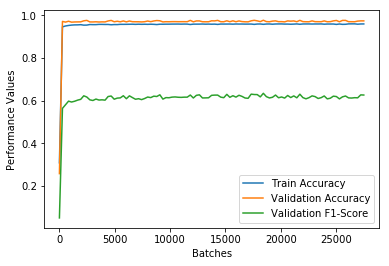

FInal Values: TrAcc: 0.960, ValAcc: 0.974, ValF1: 0.627
Test F1-Score: 0.687



In [48]:
NN = FF_Model(layers=[50])
NN.build_graph()
_,_,_,_ = NN.train(sets, epochs=5, batch=50, show_plot=True, show_progress=True)

In [49]:
res = NN.predict(sets['test_set'])
tru = np.argmax(sets['test_labels'], 1)

In [50]:
TP = len([a for a in range(len(tru)) if (res[a] == 0) and (tru[a] == 0)])
TN = len([a for a in range(len(tru)) if (res[a] == 1) and (tru[a] == 1)])
FP = len([a for a in range(len(tru)) if (res[a] == 0) and (tru[a] == 1)])
FN = len([a for a in range(len(tru)) if (res[a] == 1) and (tru[a] == 0)])
TFPN = [TP, TN, FP, FN]
print('TP\tTN\tFP\tFN\n{}\t{}\t{}\t{}'.format(*TFPN))

TP	TN	FP	FN
376	10437	301	42


In [51]:
print(', '.join([sets['test_words'][a] for a in range(len(sets['test_words'])) if res[a] == 0 and tru[a] == 1]))

codeine, (, ), sodium, potassium, chloride, magnesium, sodium, potassium, chloride, magnesium, q.a.c, inhibitor, tylenol, analgesics, insulin, ophthalmologic, (, (, hep, (, ), micro, (, (, (, (, ), (, ), (, ), ), sedation, (, ), antibiotics, ), (, ), ), coumadin, ), gemfibrozil, lipitor, aspirin, ), insulin, ), ), (, ), <num>-<num>;, caffeine, (, ), (, ), (, ), (, ), (, ), (, ), (, ), morphine, toxoid, sodium, potassium, chloride, calcium, magnesium, (, ), digoxin, digoxin, amiodarone, heparin, coumadin, heparin, iron, amiodarone, captopril, clonazepam, klonopin, digoxin, lasix, glipizide, levothyroxine, sodium, magnesium, oxide, lopressor, nitroglycerin, (, ), coumadin, simvastatin, isosorbide, mononitrate-sr, depakote, depakote, haldol, ceftriaxone, flagyl, flagyl, ensuring, lantus, aspart, aspart, aspart, insulin, aspart, antibiotics, ceftriaxone, flagyl, flagyl, rx, insulin, phoslo, depakote, folate, haldol, labetalol, lisinopril, flagyl, thiamine, norvasc, gabapentin, nephrocaps, 

In [63]:
import colorama as col

out = []
for a in range(len(sets['test_words'][:2000])):
    if res[a] == 0 and tru[a] == 1:
        out.append(col.Back.RED + sets['test_words'][a].upper() + col.Back.RESET)
    else:
        out.append(sets['test_words'][a])
        
print(' '.join(out))

record #<num> <num> | tmh | <num> | | <num> | <num>/<num>/<num> <num>:<num>:<num> am | discharge summary | signed | dis | admission date <num>/<num>/<num> report status signed discharge date <num>/<num>/<num> history ms pizzo is a <num>-year-old woman with peripheral vascular disease who recently underwent revision of her left superior femoral artery anterior tibial bypass graft , who now presents with a cool , ischemic left foot mr denman is a <num>-year-old , insulin-dependent diabetic with a long history of peripheral vascular disease as well as multiple surgical procedures she underwent a right transmetatarsal amputation in <num> and subsequently underwent a right femorla distal saphenous vein bypass graft in <num> which was later revised in <num> she seems to be doing well with the left side until july of this year , at which time she underwent a left superficial femoral artery to anterior tibial artery bypass using non-reversed basilic vein harvested from the right arm she , howe

In [59]:
proba = []
for i in range(len(res)):
    if not (sets['test_words'][i] == ')' or sets['test_words'][i] == '('):
        proba.append([sets['test_words'][i], res[i], tru[i]])

In [60]:
sk.metrics.f1_score(np.array(proba)[:,2].astype(int), np.array(proba)[:,1].astype(int), pos_label=0, average='binary')

0.77449822904368359

In [61]:
TP = len([a for a in range(len(proba)) if (proba[a][1] == 0) and (proba[a][2] == 0)])
TN = len([a for a in range(len(proba)) if (proba[a][1] == 1) and (proba[a][2] == 1)])
FP = len([a for a in range(len(proba)) if (proba[a][1] == 0) and (proba[a][2] == 1)])
FN = len([a for a in range(len(proba)) if (proba[a][1] == 1) and (proba[a][2] == 0)])
TFPN = [TP, TN, FP, FN]
print('TP\tTN\tFP\tFN\n{}\t{}\t{}\t{}'.format(*TFPN))

TP	TN	FP	FN
328	10437	149	42


# HyperParameter Scan

In [ ]:
emb_num = 1
NN_num = 1
emb_sizes = [30, 50, 100]
target_saturations = [0.05, 0.1, 0.3]
layers = [[30], [50], [100]]
dropouts = [0.3, 0.5, 0.8, 1.0]
learn_rates = [0.001, 0.01, 0.1]
epoch_nums = [10, 50, 100]
batch_sizes = [10, 50, 100]


model_num = emb_num * NN_num * len(emb_sizes) * len(layers) * len(dropouts) * \
            len(learn_rates) * len(epoch_nums) * len(batch_sizes) * len(target_saturations)
target = target_dict['medications']
report_percentage = 10

print(model_num)

In [ ]:
labelled_cases = Dataset.get_DS(labelled='yes')
labelled_cases.process_for_testing()

In [ ]:
iterations = [emb_sizes, target_saturations, layers, dropouts, learn_rates, epoch_nums, batch_sizes]

In [ ]:
n = 0
parameters = []
results = []
timestamp = re.sub(r':', '-', str(datetime.datetime.now()).split('.')[0])

f = open('tests/Model2/' + timestamp, 'w+')
print('EmbSz:\tSat:\tLay:\tDrop:\tLeRa:\tEpochs:\tBatSz:\tF1:')
f.write('EmbSz:\tSat:\tLay:\tDrop:\tLeRa:\tEpochs:\tBatSz:\tF1:\n')
for par in itertools.product(*iterations):
    best = 0
    parameters.append(par)
    for i in range(emb_num):
        model = Word2Vec(sentences, min_count=1, size=par[0])
        sets = fn.get_ff_traintest(labelled_cases, model)
        fn.saturate_training_set_labels(sets, model, target, par[1])
        for j in range(NN_num):
            n += 1
            print('Model Number: {}/{}'.format(n, model_num), end='\r')
            NN = FF_Model(input_size=par[0], layers=par[2], dropout=par[3], learn_rate=par[4])
            NN.build_graph()
            _, _, _, score = NN.train(sets, epochs=par[5], batch=par[6], report_percentage=report_percentage)
            best = max(best, score)
    results.append(best)
    print('{}\t{}\t{}\t{}\t{}\t{}\t{}\t{:.4f}'.format(*parameters[-1], results[-1]))
    f.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\t{:.4f}\n'.format(*parameters[-1], results[-1]))
    
print('Max Performance: {:.4f}'.format(max(results)))  
f.write('Max Performance: {:.4f}\n'.format(max(results)))
f.close()